In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
from joblib import dump
import time
from kafka import KafkaProducer
from scipy.stats import shapiro
from sklearn.ensemble import IsolationForest,RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.feature_selection import RFE , mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
import matplotlib as mpl
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, roc_auc_score,roc_curve ,f1_score, precision_score, recall_score,fbeta_score,confusion_matrix
mpl.rcParams['agg.path.chunksize'] = 100000  # ou plus
sns.set(style="whitegrid")

C:\Users\Lenovo\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Chemin vers ton fichier CSV
csv_file = "large_ecommerce_transactions.csv"

# Lire le fichier CSV en DataFrame
df = pd.read_csv(csv_file,sep=',')

In [3]:
filtered_row = df[
    (df['user_id'] == 'USER_08413') &
    (df['timestamp'] == '2024-08-21T13:16:17.127120') &
    (df['amount'] == 1083.23) &
    (df['user_segment'] == 'high_spender') &
    (df['payment_method'] == 'paypal') 
]

In [4]:
filtered_row['is_anomaly']

198    False
Name: is_anomaly, dtype: bool

In [5]:
print(df.shape) 

(1000000, 29)


In [6]:
# Afficher toutes les colonnes (très utile si pandas les cache)
pd.set_option('display.max_columns', None)

# Afficher les 2 premières lignes
print(df.head(2))

                         transaction_id     user_id  \
0  21045931-a280-4333-a61d-ae3e20b0c6b4  USER_04243   
1  e92e7977-cc78-4e28-a82a-5da06137cb1a  USER_07761   

                    timestamp   amount  quantity  hour_of_day  day_of_week  \
0  2024-08-20T21:49:54.594510   430.22         3           21            1   
1  2024-08-20T22:07:20.594510  1380.61         3           22            1   

   month  time_since_last  ip_geodist  items_per_product  amount_per_item  \
0      8          5861.79         0.0                1.0           143.41   
1      8         13092.75         0.0                1.0           460.20   

     user_segment payment_method  country  is_anomaly anomaly_type  \
0  medium_spender     debit_card  Germany       False          NaN   
1     low_spender         paypal      USA       False          NaN   

   rolling_mean_amount_5  rolling_std_amount_5  rolling_max_amount_5  \
0                 430.22                   0.0                430.22   
1           

In [7]:
# Afficher les 2 dernieres lignes
print(df.tail(2))

                              transaction_id     user_id  \
999998  63b1a94b-bae5-4b5a-a683-aecb97cdbd19  USER_07592   
999999  cceda33e-793c-47db-815e-3413ac21f872  USER_07592   

                         timestamp   amount  quantity  hour_of_day  \
999998  2025-03-19T08:15:54.951460  1422.46         5            8   
999999  2025-03-20T09:27:36.129311   193.90         3            9   

        day_of_week  month  time_since_last  ip_geodist  items_per_product  \
999998            2      3         68507.71         0.0                1.0   
999999            3      3         90701.18         0.0                1.0   

        amount_per_item    user_segment payment_method country  is_anomaly  \
999998           284.49  medium_spender      apple_pay     USA       False   
999999            64.63  medium_spender      apple_pay     USA       False   

       anomaly_type  rolling_mean_amount_5  rolling_std_amount_5  \
999998          NaN              10146.602          19587.988350   
99

In [8]:
print(df.columns)          # noms des colonnes
print(df.dtypes)           # types des données (int, float, object...)

Index(['transaction_id', 'user_id', 'timestamp', 'amount', 'quantity',
       'hour_of_day', 'day_of_week', 'month', 'time_since_last', 'ip_geodist',
       'items_per_product', 'amount_per_item', 'user_segment',
       'payment_method', 'country', 'is_anomaly', 'anomaly_type',
       'rolling_mean_amount_5', 'rolling_std_amount_5', 'rolling_max_amount_5',
       'rolling_mean_amount_10', 'rolling_std_amount_10',
       'rolling_max_amount_10', 'rolling_mean_amount_30',
       'rolling_std_amount_30', 'rolling_max_amount_30', 'amount_deviation_5',
       'amount_deviation_10', 'amount_deviation_30'],
      dtype='object')
transaction_id             object
user_id                    object
timestamp                  object
amount                    float64
quantity                    int64
hour_of_day                 int64
day_of_week                 int64
month                       int64
time_since_last           float64
ip_geodist                float64
items_per_product         floa

In [9]:
# Loking for a duplicated row 
df.duplicated().sum()

0

In [18]:
df.describe()

,amount,quantity,hour_of_day,day_of_week,month,time_since_last,ip_geodist,items_per_product,amount_per_item,rolling_mean_amount_5,rolling_std_amount_5,rolling_max_amount_5,rolling_mean_amount_10,rolling_std_amount_10,rolling_max_amount_10,rolling_mean_amount_30,rolling_std_amount_30,rolling_max_amount_30,amount_deviation_5,amount_deviation_10,amount_deviation_30
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000.000000,1000000.000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1112.229642,3.380236,11.511836,3.018225,7.844189,7166.913161,18.120713,1.0,293.493208,1111.261398,1197.488335,3029.01714,1110.670127,1408.006886,4495.775514,1111.958618,1751.400466,8265.182186,886.765535,944.634998,956.872669
std,3585.224899,3.173724,6.916672,2.004024,4.188445,10150.654589,248.594669,0.0,478.757315,1708.253377,3311.021693,7493.58042,1322.156149,3222.036628,10144.227120,1027.481702,3051.662134,15583.904969,3016.166345,3185.815565,3292.880985
min,3.790000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,3.790000,7.050000,0.000000,7.05000,7.050000,0.000000,7.050000,7.050000,0.000000,7.050000,0.000000,0.000000,0.000000
25%,213.527500,2.000000,6.000000,1.000000,2.000000,1291.770000,0.000000,1.0,88.020000,466.463500,369.105944,1055.64000,523.690000,498.783424,1585.790000,579.358877,599.307425,2216.550000,173.594000,218.431000,261.880250
50%,529.935000,3.000000,12.000000,3.000000,10.000000,3692.470000,0.000000,1.0,169.300000,779.196000,651.830339,1774.28000,817.576000,729.694516,2295.345000,877.579500,840.558097,3237.280000,406.968000,460.036000,514.653452
75%,1255.290000,4.000000,17.000000,5.000000,11.000000,8925.080000,0.000000,1.0,359.060000,1234.383000,1000.323124,2671.89000,1258.264500,1066.159965,3384.490000,1334.939333,1338.985625,5796.170000,801.070500,872.108000,941.865167
max,275616.810000,120.000000,23.000000,6.000000,12.000000,291375.680000,4999.797371,1.0,51031.280000,181035.350000,125954.887394,275616.81000,181035.350000,125954.887394,275616.810000,181035.350000,125954.887394,275616.810000,217968.200000,244875.492000,263889.876000


In [19]:
df.describe(include='all') # inclut les colonnes non numériques aussi

,transaction_id,user_id,timestamp,amount,quantity,hour_of_day,day_of_week,month,time_since_last,ip_geodist,items_per_product,amount_per_item,user_segment,payment_method,country,is_anomaly,anomaly_type,rolling_mean_amount_5,rolling_std_amount_5,rolling_max_amount_5,rolling_mean_amount_10,rolling_std_amount_10,rolling_max_amount_10,rolling_mean_amount_30,rolling_std_amount_30,rolling_max_amount_30,amount_deviation_5,amount_deviation_10,amount_deviation_30
count,1000000,1000000,1000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.0,1000000.000000,1000000,1000000,1000000,1000000,19903,1000000.000000,1000000.000000,1000000.00000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
unique,1000000,10000,999997,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,5,6,2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,21045931-a280-4333-a61d-ae3e20b0c6b4,USER_02905,2024-11-17T21:55:57.594510,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,medium_spender,apple_pay,France,False,amount,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,142,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,401186,209087,169424,980097,5045,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,1112.229642,3.380236,11.511836,3.018225,7.844189,7166.913161,18.120713,1.0,293.493208,NaN,NaN,NaN,NaN,NaN,1111.261398,1197.488335,3029.01714,1110.670127,1408.006886,4495.775514,1111.958618,1751.400466,8265.182186,886.765535,944.634998,956.872669
std,NaN,NaN,NaN,3585.224899,3.173724,6.916672,2.004024,4.188445,10150.654589,248.594669,0.0,478.757315,NaN,NaN,NaN,NaN,NaN,1708.253377,3311.021693,7493.58042,1322.156149,3222.036628,10144.227120,1027.481702,3051.662134,15583.904969,3016.166345,3185.815565,3292.880985
min,NaN,NaN,NaN,3.790000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,3.790000,NaN,NaN,NaN,NaN,NaN,7.050000,0.000000,7.05000,7.050000,0.000000,7.050000,7.050000,0.000000,7.050000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,213.527500,2.000000,6.000000,1.000000,2.000000,1291.770000,0.000000,1.0,88.020000,NaN,NaN,NaN,NaN,NaN,466.463500,369.105944,1055.64000,523.690000,498.783424,1585.790000,579.358877,599.307425,2216.550000,173.594000,218.431000,261.880250
50%,NaN,NaN,NaN,529.935000,3.000000,12.000000,3.000000,10.000000,3692.470000,0.000000,1.0,169.300000,NaN,NaN,NaN,NaN,NaN,779.196000,651.830339,1774.28000,817.576000,729.694516,2295.345000,877.579500,840.558097,3237.280000,406.968000,460.036000,514.653452
75%,NaN,NaN,NaN,1255.290000,4.000000,17.000000,5.000000,11.000000,8925.080000,0.000000,1.0,359.060000,NaN,NaN,NaN,NaN,NaN,1234.383000,1000.323124,2671.89000,1258.264500,1066.159965,3384.490000,1334.939333,1338.985625,5796.170000,801.070500,872.108000,941.865167


In [20]:
print(df.nunique())        # nombre de valeurs uniques par colonne

transaction_id            1000000
user_id                     10000
timestamp                  999997
amount                     277848
quantity                       65
hour_of_day                    24
day_of_week                     7
month                           8
time_since_last            693098
ip_geodist                   6079
items_per_product               1
amount_per_item            122722
user_segment                    4
payment_method                  5
country                         6
is_anomaly                      2
anomaly_type                    4
rolling_mean_amount_5      788080
rolling_std_amount_5       989869
rolling_max_amount_5       222706
rolling_mean_amount_10     847940
rolling_std_amount_10      989861
rolling_max_amount_10      155416
rolling_mean_amount_30     953907
rolling_std_amount_30      989863
rolling_max_amount_30       79356
amount_deviation_5         840379
amount_deviation_10        894830
amount_deviation_30        964036
dtype: int64


In [21]:
df['timestamp']

0         2024-08-20T21:49:54.594510
1         2024-08-20T22:07:20.594510
2         2024-08-20T22:09:23.896416
3         2024-08-20T22:26:10.953191
4         2024-08-20T23:06:16.594510
                     ...            
999995    2025-03-18T09:54:37.055374
999996    2025-03-18T13:13:48.059370
999997    2025-03-18T13:14:07.238992
999998    2025-03-19T08:15:54.951460
999999    2025-03-20T09:27:36.129311
Name: timestamp, Length: 1000000, dtype: object

In [22]:
is_sorted = df['timestamp'].is_monotonic_increasing
print("Le dataset est-il trié par timestamp ?", is_sorted)

Le dataset est-il trié par timestamp ? True


In [23]:
print(df['items_per_product'].nunique())  # Si == 1 → colonne constante

1


In [24]:
# cette colonne constante n'apporte aucune information discriminante donc on peut l'eliminer
df.drop(columns=['items_per_product'], inplace=True)

In [25]:
df.isnull().sum()

transaction_id                 0
user_id                        0
timestamp                      0
amount                         0
quantity                       0
hour_of_day                    0
day_of_week                    0
month                          0
time_since_last                0
ip_geodist                     0
amount_per_item                0
user_segment                   0
payment_method                 0
country                        0
is_anomaly                     0
anomaly_type              980097
rolling_mean_amount_5          0
rolling_std_amount_5           0
rolling_max_amount_5           0
rolling_mean_amount_10         0
rolling_std_amount_10          0
rolling_max_amount_10          0
rolling_mean_amount_30         0
rolling_std_amount_30          0
rolling_max_amount_30          0
amount_deviation_5             0
amount_deviation_10            0
amount_deviation_30            0
dtype: int64

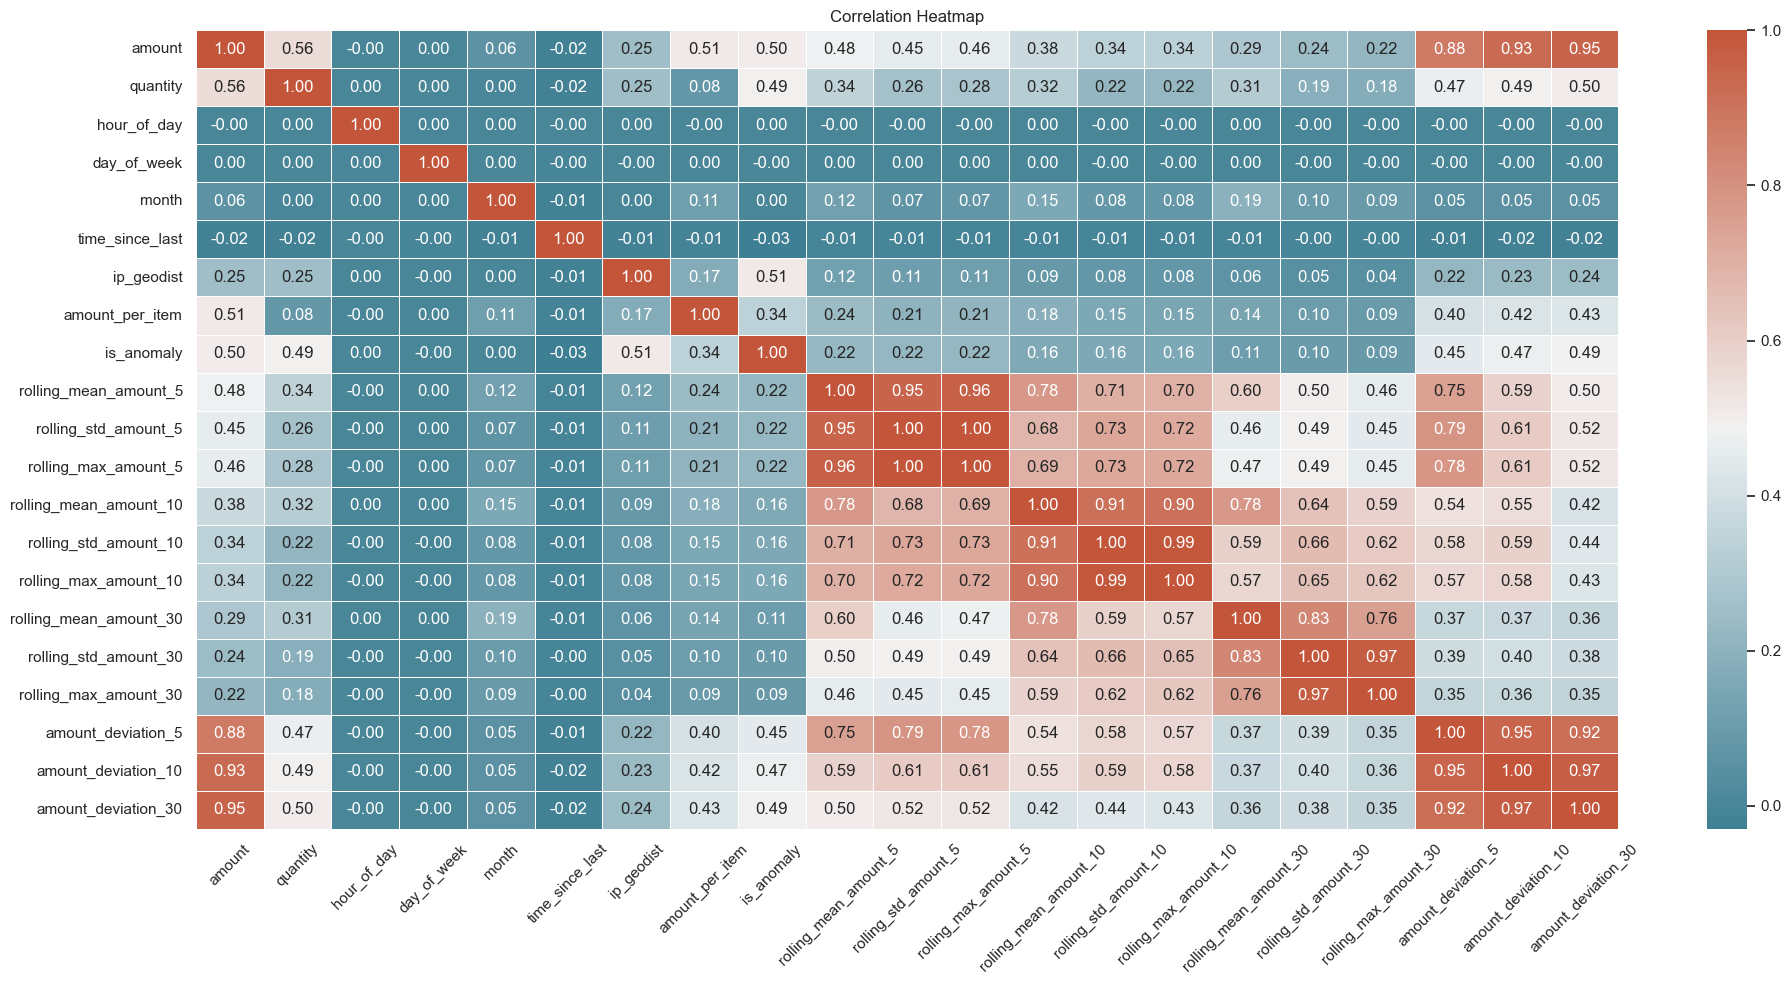

In [15]:
correlation = df.corr(numeric_only=True)
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [26]:
numeric_columns = df.select_dtypes(include=[np.number])

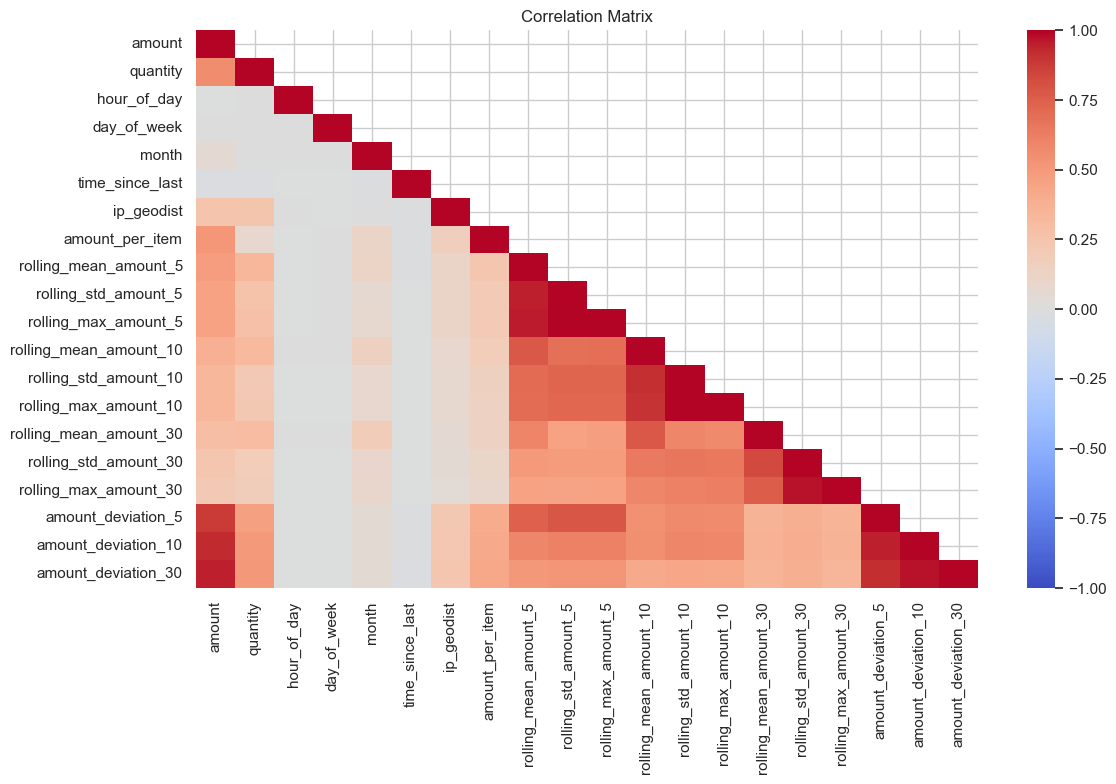

In [17]:
corr_matrix = numeric_columns.corr()
upper_triangle = np.triu(corr_matrix)
mask = np.triu(np.ones_like(corr_matrix), k=1)
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, mask=mask, cmap="coolwarm", vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

In [18]:
#Finding out the Pair of features which are highly correlated
def correlated_feature_pair_finder(df,threashold=0.7):
    correlation_matrix=df.corr()
    correlated_pairs=[]
    for i in range (len(correlation_matrix.columns)):
        for j in range(i+1,len(correlation_matrix.columns)):
            if abs(correlation_matrix.iloc[i,j])>threashold:
                pairs=(correlation_matrix.columns[i],correlation_matrix.columns[j])
                correlated_pairs.append(pairs)
    return correlated_pairs

In [19]:
correlated_feature_pair_finder(numeric_columns)

[('amount', 'amount_deviation_5'),
 ('amount', 'amount_deviation_10'),
 ('amount', 'amount_deviation_30'),
 ('rolling_mean_amount_5', 'rolling_std_amount_5'),
 ('rolling_mean_amount_5', 'rolling_max_amount_5'),
 ('rolling_mean_amount_5', 'rolling_mean_amount_10'),
 ('rolling_mean_amount_5', 'rolling_std_amount_10'),
 ('rolling_mean_amount_5', 'rolling_max_amount_10'),
 ('rolling_mean_amount_5', 'amount_deviation_5'),
 ('rolling_std_amount_5', 'rolling_max_amount_5'),
 ('rolling_std_amount_5', 'rolling_std_amount_10'),
 ('rolling_std_amount_5', 'rolling_max_amount_10'),
 ('rolling_std_amount_5', 'amount_deviation_5'),
 ('rolling_max_amount_5', 'rolling_std_amount_10'),
 ('rolling_max_amount_5', 'rolling_max_amount_10'),
 ('rolling_max_amount_5', 'amount_deviation_5'),
 ('rolling_mean_amount_10', 'rolling_std_amount_10'),
 ('rolling_mean_amount_10', 'rolling_max_amount_10'),
 ('rolling_mean_amount_10', 'rolling_mean_amount_30'),
 ('rolling_std_amount_10', 'rolling_max_amount_10'),
 ('rol

In [27]:
is_anomaly = df['is_anomaly']
legit = is_anomaly[is_anomaly==False].count()
fraud = is_anomaly[is_anomaly==True].count()

In [28]:
legit

980097

In [29]:
fraud

19903

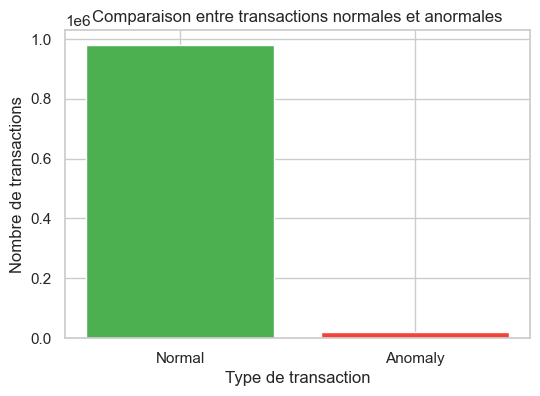

In [30]:
# Création du graphique
plt.figure(figsize=(6, 4))
plt.bar(['Normal', 'Anomaly'], [legit, fraud], color=['#4CAF50', '#F44336'])

# Titre et labels
plt.title('Comparaison entre transactions normales et anormales')
plt.xlabel('Type de transaction')
plt.ylabel('Nombre de transactions')

# Affichage
plt.show()

payment_method
apple_pay      209087
debit_card     201083
credit_card    199994
google_pay     196976
paypal         192860
Name: count, dtype: int64
Axes(0.125,0.11;0.775x0.77)


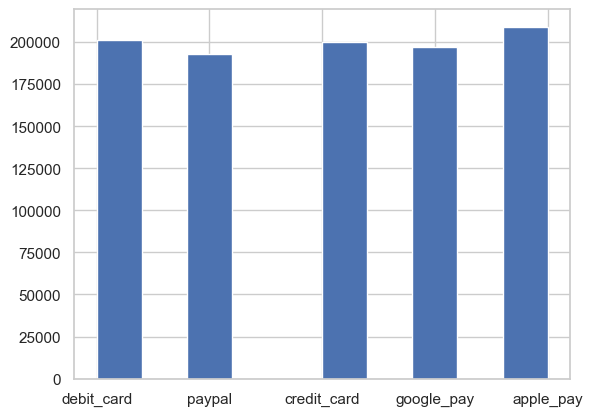

In [31]:
print(df['payment_method'].value_counts())  # fréquence des moyens de paiement
print(df['payment_method'].hist())          

In [23]:
def shapiro_test(data, alpha=0.05):
    # Perform Shapiro-Wilk test
    stat, p_value = shapiro(data)
    # Print the test result
    print("Shapiro-Wilk Test Result:")
    print("Test Statistic:", stat)
    print("p-value:", p_value)
    # Interpret the test result
    if p_value > alpha:
        print("Conclusion: Fail to reject the null hypothesis (data is normally distributed)")
    else:
        print("Conclusion: Reject the null hypothesis (data is not normally distributed)")

In [61]:
shapiro_test(df.select_dtypes(include=[np.number]))

Shapiro-Wilk Test Result:
Test Statistic: 0.2749672532081604
p-value: 0.0
Conclusion: Reject the null hypothesis (data is not normally distributed)


C:\Users\Lenovo\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [ ]:
print(df['user_segment'].value_counts())
# print(df['is_anomaly'].value_counts())
print(df['country'].value_counts())
print(df['anomaly_type'].value_counts(dropna=False))  # inclut les NaN
print(df['payment_method'].value_counts())

### Feature selection

In [32]:
numeric_columns

,amount,quantity,hour_of_day,day_of_week,month,time_since_last,ip_geodist,amount_per_item,rolling_mean_amount_5,rolling_std_amount_5,rolling_max_amount_5,rolling_mean_amount_10,rolling_std_amount_10,rolling_max_amount_10,rolling_mean_amount_30,rolling_std_amount_30,rolling_max_amount_30,amount_deviation_5,amount_deviation_10,amount_deviation_30
0,430.22,3,21,1,8,5861.79,0.0,143.41,430.220,0.000000,430.22,430.220,0.000000,430.22,430.220000,0.000000,430.22,0.000,0.000,0.000000
1,1380.61,3,22,1,8,13092.75,0.0,460.20,1380.610,0.000000,1380.61,1380.610,0.000000,1380.61,1380.610000,0.000000,1380.61,0.000,0.000,0.000000
2,78.74,2,22,1,8,123.30,0.0,39.37,729.675,920.561105,1380.61,729.675,920.561105,1380.61,729.675000,920.561105,1380.61,650.935,650.935,650.935000
3,825.46,4,22,1,8,2176.36,0.0,206.37,627.840,279.476884,825.46,627.840,279.476884,825.46,627.840000,279.476884,825.46,197.620,197.620,197.620000
4,1026.41,1,23,1,8,7545.08,0.0,1026.41,1026.410,0.000000,1026.41,1026.410,0.000000,1026.41,1026.410000,0.000000,1026.41,0.000,0.000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1239.64,4,9,1,3,53596.63,0.0,309.91,1063.726,597.652820,1863.04,906.536,598.695188,1863.04,933.772333,684.764485,3018.39,175.914,333.104,305.867667
999996,1025.55,5,13,1,3,11951.00,0.0,205.11,1015.764,586.952924,1863.04,997.497,530.440762,1863.04,956.867667,675.412797,3018.39,9.786,28.053,68.682333
999997,45182.32,36,13,1,3,19.18,0.0,1255.06,9934.476,19711.438765,45182.32,5372.259,13997.040632,45182.32,2457.787000,8096.175664,45182.32,35247.844,39810.061,42724.533000
999998,1422.46,5,8,2,3,68507.71,0.0,284.49,10146.602,19587.988350,45182.32,5449.884,13970.045076,45182.32,2483.728667,8091.409668,45182.32,8724.142,4027.424,1061.268667


### Encodage 

In [33]:
x=numeric_columns
y=df['is_anomaly'].astype(int)

In [34]:
ord_enc = OrdinalEncoder(categories=[['low_spender', 'medium_spender', 'high_spender', 'vip']])
x['user_segment_encoded'] = ord_enc.fit_transform(df[['user_segment']])

In [35]:
# Sauvegarder l'encodeur
dump(ord_enc, "user_segment_encoder.joblib")

['user_segment_encoder.joblib']

In [36]:
dummies_payment = pd.get_dummies(df['payment_method'])
x = pd.concat([x, dummies_payment], axis=1)

In [42]:
# Sauvegarder les colonnes générées pour payment_method
with open("payment_method_columns.json", "w") as f:
    json.dump(dummies_payment.columns.tolist(), f)

In [37]:
dummies_contries = pd.get_dummies(df['country'])
x = pd.concat([x, dummies_contries], axis=1)

In [44]:
# Sauvegarder les colonnes générées pour country
with open("country_columns.json", "w") as f:
    json.dump(dummies_contries.columns.tolist(), f)

In [38]:
x = x.astype({col: int for col in x.select_dtypes(include='bool').columns})

### Feature engineering

In [39]:
df['is_anomaly'].sum()

19903

In [40]:
(df['amount'] > df['amount'].quantile(0.98)).astype(int).sum()

20000

In [41]:
x['high_value'] = (x['amount'] > x['amount'].quantile(0.98)).astype(int)

In [42]:
x['is_fast_transaction'] = (x['time_since_last'] < 60).astype(int)  # < 1min

In [43]:
x['is_night'] = (x['hour_of_day'].between(0, 6)).astype(int)

In [44]:
x['high_risk_combo'] = (
    (x['amount'] > x['amount'].quantile(0.95)) & 
    (x['is_night'] == 1) & 
    (x['is_fast_transaction'] == 1)
).astype(int)

In [45]:
x

,amount,quantity,hour_of_day,day_of_week,month,time_since_last,ip_geodist,amount_per_item,rolling_mean_amount_5,rolling_std_amount_5,rolling_max_amount_5,rolling_mean_amount_10,rolling_std_amount_10,rolling_max_amount_10,rolling_mean_amount_30,rolling_std_amount_30,rolling_max_amount_30,amount_deviation_5,amount_deviation_10,amount_deviation_30,user_segment_encoded,apple_pay,credit_card,debit_card,google_pay,paypal,Australia,Canada,France,Germany,UK,USA,high_value,is_fast_transaction,is_night,high_risk_combo
0,430.22,3,21,1,8,5861.79,0.0,143.41,430.220,0.000000,430.22,430.220,0.000000,430.22,430.220000,0.000000,430.22,0.000,0.000,0.000000,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
1,1380.61,3,22,1,8,13092.75,0.0,460.20,1380.610,0.000000,1380.61,1380.610,0.000000,1380.61,1380.610000,0.000000,1380.61,0.000,0.000,0.000000,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,78.74,2,22,1,8,123.30,0.0,39.37,729.675,920.561105,1380.61,729.675,920.561105,1380.61,729.675000,920.561105,1380.61,650.935,650.935,650.935000,0.0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
3,825.46,4,22,1,8,2176.36,0.0,206.37,627.840,279.476884,825.46,627.840,279.476884,825.46,627.840000,279.476884,825.46,197.620,197.620,197.620000,1.0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,1026.41,1,23,1,8,7545.08,0.0,1026.41,1026.410,0.000000,1026.41,1026.410,0.000000,1026.41,1026.410000,0.000000,1026.41,0.000,0.000,0.000000,0.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1239.64,4,9,1,3,53596.63,0.0,309.91,1063.726,597.652820,1863.04,906.536,598.695188,1863.04,933.772333,684.764485,3018.39,175.914,333.104,305.867667,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
999996,1025.55,5,13,1,3,11951.00,0.0,205.11,1015.764,586.952924,1863.04,997.497,530.440762,1863.04,956.867667,675.412797,3018.39,9.786,28.053,68.682333,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
999997,45182.32,36,13,1,3,19.18,0.0,1255.06,9934.476,19711.438765,45182.32,5372.259,13997.040632,45182.32,2457.787000,8096.175664,45182.32,35247.844,39810.061,42724.533000,1.0,1,0,0,0,0,0,0,0,0,0,1,1,1,0,0
999998,1422.46,5,8,2,3,68507.71,0.0,284.49,10146.602,19587.988350,45182.32,5449.884,13970.045076,45182.32,2483.728667,8091.409668,45182.32,8724.142,4027.424,1061.268667,1.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0


### Executer ça si tu veux encoder transaction_id et user_id 

In [10]:
# Initialize label encoders
label_encoders = {}

# Apply label encoding to 'user_id', 'transaction_id'
categorical_columns = ['user_id', 'transaction_id']
for column in categorical_columns:
    le = LabelEncoder()
    x[column] = le.fit_transform(df[column])
    label_encoders[column] = le

NameError: name 'x' is not defined

### Mutual Information Gain --> pour avoir idées sur les colonnes qui vont nous aider le plus pour identifier les anomalies

In [ ]:
def plot_mutual_info(x, y):
    # Get feature names from DataFrame columns
    feature_names = x.columns.tolist()
    # Calculate mutual information scores
    mi_scores = mutual_info_classif(x, y)
    # Sort features based on mutual information scores
    sorted_indices = np.argsort(mi_scores)
    sorted_feature_names = [feature_names[i] for i in sorted_indices]
    sorted_mi_scores = [mi_scores[i] for i in sorted_indices]
    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_feature_names)), sorted_mi_scores, align='center')
    plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
    plt.xlabel('Mutual Information Gain')
    plt.ylabel('Features')
    plt.title('Mutual Information Gain for Features')
    plt.show()

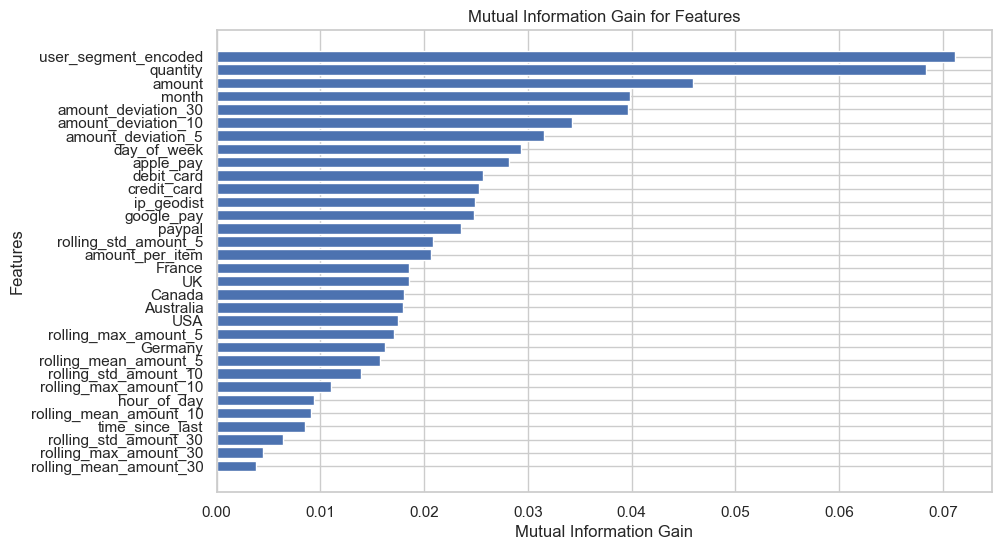

In [120]:
plot_mutual_info(x, y)

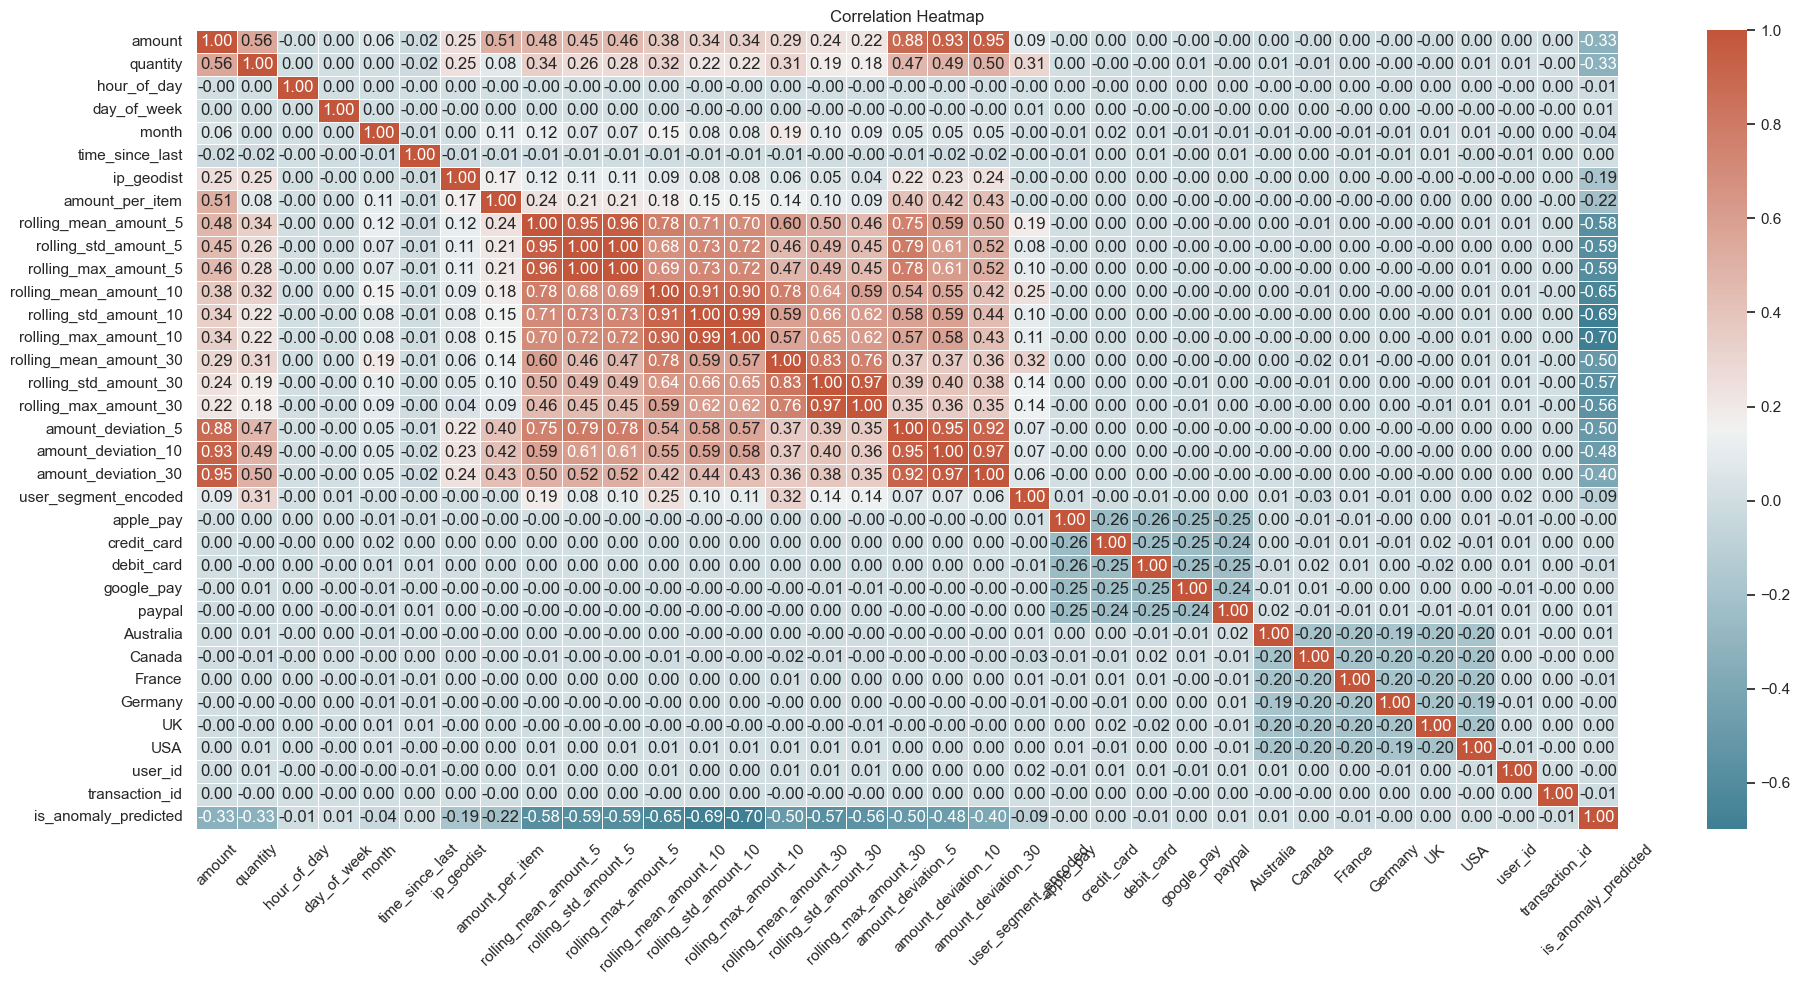

In [152]:
correlation = x.corr()
plt.figure(figsize=(20, 10))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(correlation, annot=True, cmap=cmap, fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### Outliers 

### Method-1 Z-Score Method

In [72]:
def count_outliers_zscore(data, threshold=3):
    # Calculate z-scores for each column using vectorized operations for efficiency
    z_scores = (data - data.mean(axis=0)) / data.std(axis=0)
    # Count outliers based on the specified threshold (consider both positive and negative deviations)
    outlier_counts = ((z_scores.abs() > threshold).sum(axis=0))
    return outlier_counts

In [73]:
#creating a copy of dataset to simulate the results so that our original data stay original.
df_o=x.copy()

In [74]:
outlier=count_outliers_zscore(df_o, threshold=3)

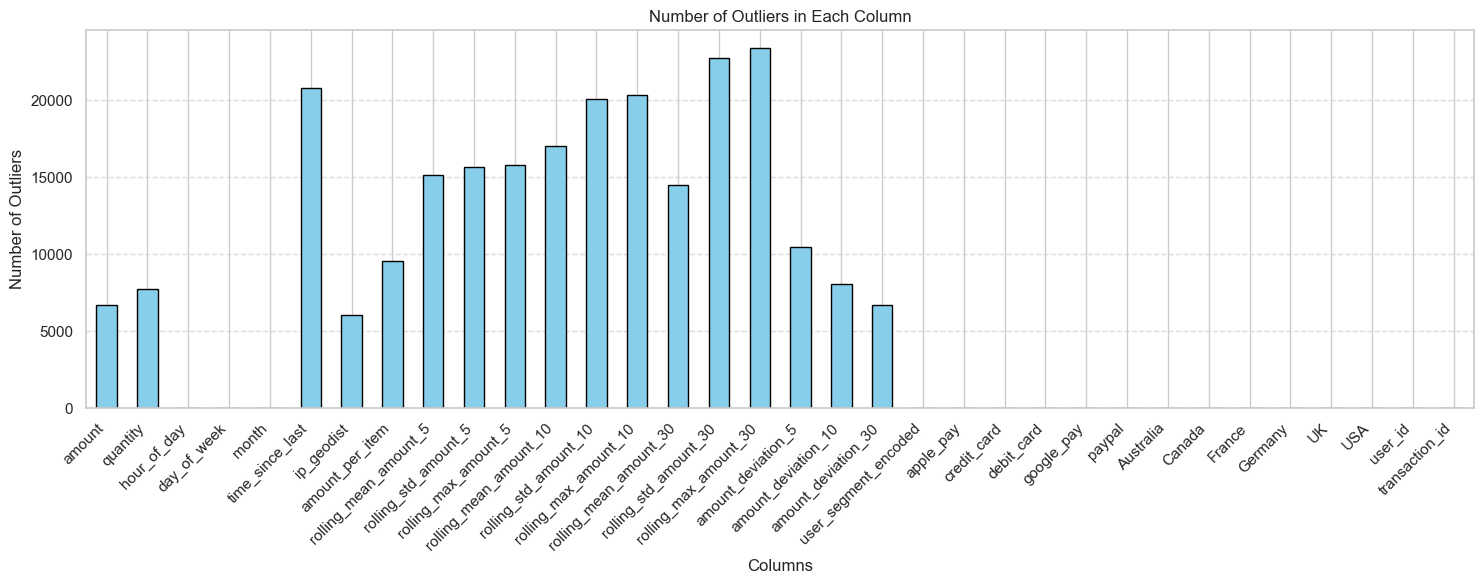

In [76]:
# Plot the results
outlier.plot(kind='bar', figsize=(15, 6), color='skyblue', edgecolor='black')

plt.title('Number of Outliers in Each Column')
plt.xlabel('Columns')
plt.ylabel('Number of Outliers')

# Amélioration : rotation et alignement des labels de l’axe X
plt.xticks(rotation=45, ha='right')

# Grille légère pour lisibilité
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Ajustement automatique des marges
plt.tight_layout()

plt.show()

### Model training

In [214]:
correlated_feature_pair_finder(x)

[('amount', 'amount_deviation_5'),
 ('amount', 'amount_deviation_10'),
 ('amount', 'amount_deviation_30'),
 ('hour_of_day', 'is_night'),
 ('rolling_mean_amount_5', 'rolling_std_amount_5'),
 ('rolling_mean_amount_5', 'rolling_max_amount_5'),
 ('rolling_mean_amount_5', 'rolling_mean_amount_10'),
 ('rolling_mean_amount_5', 'rolling_std_amount_10'),
 ('rolling_mean_amount_5', 'rolling_max_amount_10'),
 ('rolling_mean_amount_5', 'amount_deviation_5'),
 ('rolling_std_amount_5', 'rolling_max_amount_5'),
 ('rolling_std_amount_5', 'rolling_std_amount_10'),
 ('rolling_std_amount_5', 'rolling_max_amount_10'),
 ('rolling_std_amount_5', 'amount_deviation_5'),
 ('rolling_max_amount_5', 'rolling_std_amount_10'),
 ('rolling_max_amount_5', 'rolling_max_amount_10'),
 ('rolling_max_amount_5', 'amount_deviation_5'),
 ('rolling_mean_amount_10', 'rolling_std_amount_10'),
 ('rolling_mean_amount_10', 'rolling_max_amount_10'),
 ('rolling_mean_amount_10', 'rolling_mean_amount_30'),
 ('rolling_std_amount_10', 'r

### Train - validation - test split 

In [46]:
n_total = len(x)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.2)
n_test = n_total - n_train - n_val  # pour couvrir tout le dataset

X_train = x.iloc[:n_train]
y_train = y.iloc[:n_train]

X_val = x.iloc[n_train:n_train + n_val]
y_val = y.iloc[n_train:n_train + n_val]

X_test = x.iloc[n_train + n_val:]
y_test = y.iloc[n_train + n_val:]

print(f"Train : {len(X_train)} lignes")
print(f"Validation : {len(X_val)} lignes")
print(f"Test : {len(X_test)} lignes")

Train : 600000 lignes
Validation : 200000 lignes
Test : 200000 lignes


In [47]:
X_train.columns

Index(['amount', 'quantity', 'hour_of_day', 'day_of_week', 'month',
       'time_since_last', 'ip_geodist', 'amount_per_item',
       'rolling_mean_amount_5', 'rolling_std_amount_5', 'rolling_max_amount_5',
       'rolling_mean_amount_10', 'rolling_std_amount_10',
       'rolling_max_amount_10', 'rolling_mean_amount_30',
       'rolling_std_amount_30', 'rolling_max_amount_30', 'amount_deviation_5',
       'amount_deviation_10', 'amount_deviation_30', 'user_segment_encoded',
       'apple_pay', 'credit_card', 'debit_card', 'google_pay', 'paypal',
       'Australia', 'Canada', 'France', 'Germany', 'UK', 'USA', 'high_value',
       'is_fast_transaction', 'is_night', 'high_risk_combo'],
      dtype='object')

In [48]:
# Features numériques à normaliser
numeric_features = [
    'amount', 'quantity', 'hour_of_day', 'day_of_week', 'month',
    'time_since_last', 'ip_geodist', 'amount_per_item',
    'rolling_mean_amount_5', 'rolling_std_amount_5', 'rolling_max_amount_5',
    'rolling_mean_amount_10', 'rolling_std_amount_10', 'rolling_max_amount_10',
    'rolling_mean_amount_30', 'rolling_std_amount_30', 'rolling_max_amount_30',
    'amount_deviation_5', 'amount_deviation_10', 'amount_deviation_30'
]

# Features catégorielles/binaires (ne pas normaliser)
binary_features = [
    'user_segment_encoded', 'apple_pay', 'credit_card', 'debit_card', 
    'google_pay', 'paypal', 'Australia', 'Canada', 'France', 
    'Germany', 'UK', 'USA', 'high_value', 'is_fast_transaction', 
    'is_night', 'high_risk_combo'
]

### Normalisation

In [49]:
# Initialisation du scaler
scaler = RobustScaler()

In [53]:
import joblib

In [50]:
# Normalisation des features numériques
X_train_numeric = scaler.fit_transform(X_train[numeric_features])

# Combinaison avec les features binaires
X_train_processed = np.hstack([
    X_train_numeric,
    X_train[binary_features].values  # Non normalisées
])

In [54]:
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

In [59]:
X_train_processed

array([[-0.12579644,  0.        ,  0.81818182, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.72022611,  0.        ,  0.90909091, ...,  0.        ,
         0.        ,  0.        ],
       [-0.43867852, -0.5       ,  0.90909091, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.39996217,  0.        , -0.27272727, ...,  0.        ,
         0.        ,  0.        ],
       [-0.26119352,  0.        , -0.27272727, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.66895147,  0.5       , -0.27272727, ...,  0.        ,
         0.        ,  0.        ]])

In [44]:
# Création d'un DataFrame pour vérification
X_check = pd.DataFrame(X_train_numeric, columns=numeric_features)
print(X_check.describe().round(2))

          amount   quantity  hour_of_day  day_of_week      month  \
count  600000.00  600000.00    600000.00    600000.00  600000.00   
mean        0.54       0.19        -0.05         0.01       0.03   
std         3.35       1.59         0.63         0.50       0.55   
min        -0.50      -1.00        -1.09        -0.75      -1.00   
25%        -0.30      -0.50        -0.55        -0.50      -0.50   
50%         0.00       0.00         0.00         0.00       0.00   
75%         0.70       0.50         0.45         0.50       0.50   
max       244.84      58.50         1.00         0.75       1.00   

       time_since_last  ip_geodist  amount_per_item  rolling_mean_amount_5  \
count        600000.00   600000.00        600000.00              600000.00   
mean              0.46       18.46             0.45                   0.42   
std               1.33      250.25             1.74                   2.20   
min              -0.48        0.00            -0.61                  -1.04 

In [45]:
fraud_ratio = df['is_anomaly'].mean() * 100
print(f"Taux de fraude réel : {fraud_ratio:.2f} %")

Taux de fraude réel : 1.99 %


In [157]:
y_train.mean()

0.019995

#### *ceci nous aide pour trouver l'argument contamination de notre model* --> 2%

In [195]:
# Create the model
isolation_forest = IsolationForest(n_estimators=10000,contamination=y_train.mean(),max_samples=300000,max_features=1.0,bootstrap=False,n_jobs=-1,random_state=42,verbose=0)  # Contamination is the expected proportion of anomalies

# Fit the model
isolation_forest.fit(X_train_processed)

IsolationForest(contamination=0.019995, max_samples=300000, n_estimators=10000,
                n_jobs=-1, random_state=42)

In [ ]:
# Local Outlier Factor 
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02, novelty=True)
lof.fit(X_train_processed)

### Evaluation pour train set

### Puisque notre dataset est desiquilibré il faut utilisé le f1 score pour evaluer notre model --> on cherche à trouver le seuil qui correspond à f1score optimale 

In [467]:
# choisir un seuil de decision pour le dataset d'entrainement - premier pas 
fraud_ratio = y_train.mean() * 100
print(f"Taux de fraude réel pour train: {fraud_ratio:.2f} %")

Taux de fraude réel pour train: 2.00 %


In [212]:
# Obtenir les scores de décision (plus bas-negatif = plus anormal)
y_score = isolation_forest.decision_function(X_train_processed)

In [213]:
# threshold = np.percentile(y_score, fraud_ratio)
# Prédictions : 1 = normal, -1 = anomalie
y_pred = (y_score < final_tresh).astype(int)
# Remapper pour correspondre aux vrais labels (1 = anomalie, 0 = normal)
# y_pred = np.where(y_pred == 1, 0, 1)

In [214]:
print("Isolation Forest pour train set :")
print(classification_report(y_train, y_pred))

Isolation Forest pour train set :
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    588003
           1       0.41      0.61      0.49     11997

    accuracy                           0.97    600000
   macro avg       0.70      0.80      0.74    600000
weighted avg       0.98      0.97      0.98    600000



<Axes: >

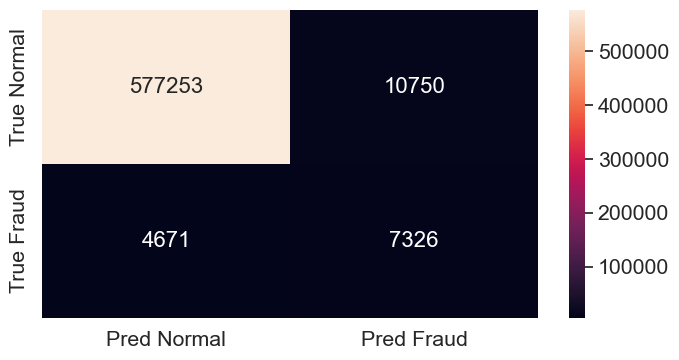

In [216]:
if_cm=confusion_matrix(y_train, y_pred)
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [217]:
# AUC-ROC
auc = roc_auc_score(y_train, -y_score)  # Utilisez les scores bruts pour AUC
print(f"AUC-ROC: {auc:.4f}")
# F1-score
f1 = f1_score(y_train, y_pred)
print(f"F1-score au seuil 2%: {f1:.4f}")

AUC-ROC: 0.8943
F1-score au seuil 2%: 0.4872


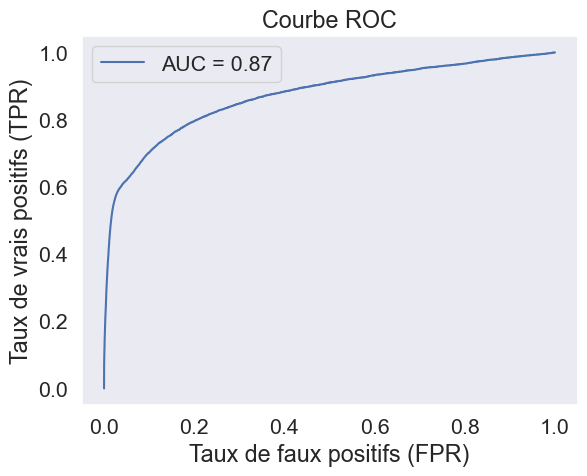

In [474]:
fpr, tpr, thresholds = roc_curve(y_train, -y_score)  # on inverse car plus négatif = plus suspect
auc_score = roc_auc_score(y_train, -y_score)

plt.plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
plt.xlabel("Taux de faux positifs (FPR)")
plt.ylabel("Taux de vrais positifs (TPR)")
plt.title("Courbe ROC")
plt.legend()
plt.grid()
plt.show()

### Evaluation pour validation set¶

In [159]:
# Normalisation des features numériques
X_val_numeric = scaler.fit_transform(X_val[numeric_features])

# Combinaison avec les features binaires
X_val_processed = np.hstack([
    X_val_numeric,
    X_val[binary_features].values  # Non normalisées
])

In [196]:
# 1. Générer les seuils
tresholds = np.linspace(-.2, .2, 200)
# 2. Obtenir les scores de décision sur le set de validation
y_scores = isolation_forest.decision_function(X_val_processed)
scores = []
for treshold in tresholds:
    y_hat = (y_scores < treshold).astype(int)
    scores.append([recall_score(y_pred=y_hat, y_true=y_val),
                 precision_score(y_pred=y_hat, y_true=y_val),
                 fbeta_score(y_pred=y_hat, y_true=y_val, beta=2)])

scores = np.array(scores)
print(scores[:, 2].max(), scores[:, 2].argmax())

0.5628737130782718 111


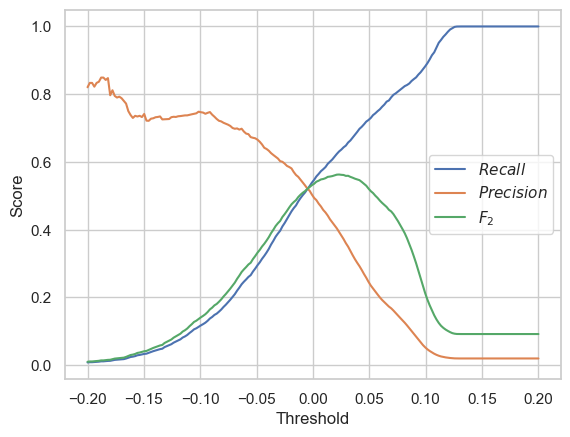

In [197]:
plt.plot(tresholds, scores[:, 0], label='$Recall$')
plt.plot(tresholds, scores[:, 1], label='$Precision$')
plt.plot(tresholds, scores[:, 2], label='$F_2$')
plt.ylabel('Score')
plt.xlabel('Threshold')
plt.legend(loc='best')
plt.show()

In [198]:
print(scores[:, 2].max(), scores[:, 2].argmax())
final_tresh = tresholds[scores[:, 2].argmax()] # ---> seuil associé
final_tresh

0.5628737130782718 111


0.023115577889447236

In [199]:
y_score_val=isolation_forest.decision_function(X_val_processed)
y_hat_val = (y_score_val < final_tresh).astype(int)

In [200]:
print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_val, y_true=y_val))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_val, y_true=y_val))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_val, y_true=y_val, beta=2))

Final threshold: 0.023116
Test Recall Score: 0.631
Test Precision Score: 0.393
Test F2 Score: 0.563


In [201]:
print("Isolation Forest pour validation set:")
print(classification_report(y_val, y_hat_val))

Isolation Forest pour validation set:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    196031
           1       0.39      0.63      0.48      3969

    accuracy                           0.97    200000
   macro avg       0.69      0.81      0.74    200000
weighted avg       0.98      0.97      0.98    200000



<Axes: >

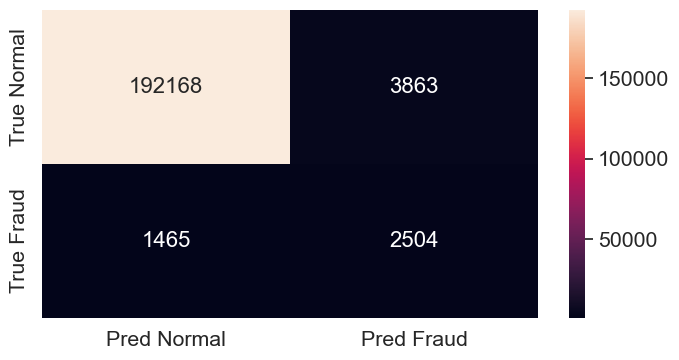

In [202]:
if_cm=confusion_matrix(y_val, y_hat_val)
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [203]:
# AUC-ROC
auc = roc_auc_score(y_val, -y_score_val)  # Utilisez les scores bruts pour AUC
print(f"AUC-ROC: {auc:.4f}")
# F1-score
f1 = f1_score(y_val, y_hat_val)
print(f"F1-score au seuil 2%: {f1:.4f}")

AUC-ROC: 0.9002
F1-score au seuil 2%: 0.4845


### Evaluation pour test set

In [204]:
X_test_numeric = scaler.transform(X_test[numeric_features]) 
# Combinaison avec les features binaires
X_test_processed = np.hstack([
    X_test_numeric,
    X_test[binary_features].values  # Non normalisées
])

In [205]:
y_score_test = isolation_forest.decision_function(X_test_processed)
y_hat_test = (y_score_test < final_tresh).astype(int)

In [206]:
print('Final threshold: %f' % final_tresh)
print('Test Recall Score: %.3f' % recall_score(y_pred=y_hat_test, y_true=y_test))
print('Test Precision Score: %.3f' % precision_score(y_pred=y_hat_test, y_true=y_test))
print('Test F2 Score: %.3f' % fbeta_score(y_pred=y_hat_test, y_true=y_test, beta=2))

Final threshold: 0.023116
Test Recall Score: 0.597
Test Precision Score: 0.519
Test F2 Score: 0.580


In [207]:
print("Isolation Forest pour test set:")
print(classification_report(y_test, y_hat_test))

Isolation Forest pour test set:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    196063
           1       0.52      0.60      0.56      3937

    accuracy                           0.98    200000
   macro avg       0.76      0.79      0.77    200000
weighted avg       0.98      0.98      0.98    200000



<Axes: >

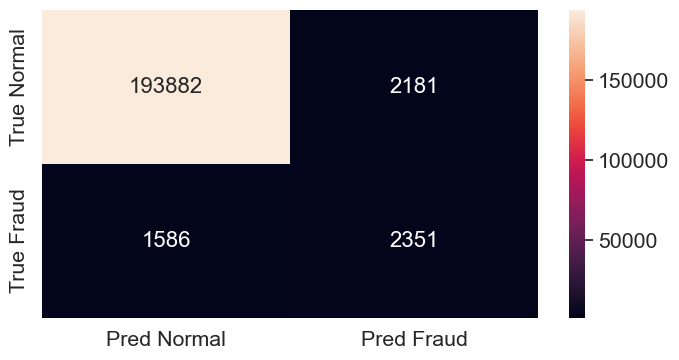

In [208]:
if_cm=confusion_matrix(y_test, y_hat_test)
df_cm = pd.DataFrame(if_cm,
                  ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
plt.figure(figsize = (8,4))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16},fmt='g')# font size

In [209]:
# AUC ROC
auc = roc_auc_score(y_test, -y_score_test)
print(f"AUC-ROC: {auc:.4f}")
# F1 score
print(f"F1-score au seuil 98% : {f1_score(y_test, y_hat_test):.2f}")

AUC-ROC: 0.8884
F1-score au seuil 98% : 0.56


In [210]:
fn = X_test[(y_test == 1) & (y_hat_test == 0)]
print(fn[['amount','is_fast_transaction','is_night']].describe())

            amount  is_fast_transaction     is_night
count  1586.000000          1586.000000  1586.000000
mean   1303.887579             0.131148     0.274275
std    1263.088487             0.337668     0.446289
min       7.740000             0.000000     0.000000
25%     275.555000             0.000000     0.000000
50%     856.845000             0.000000     0.000000
75%    2088.097500             0.000000     1.000000
max    6886.770000             1.000000     1.000000


# Sauvegarder le modèle

In [211]:
dump(isolation_forest, 'isolation_forest_model_version_of_300000.joblib')
with open("isolation_forest_threshold_version_of_300000.json", "w") as f:
    json.dump({"threshold": final_tresh}, f)